In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(20987, 28)
(20987, 3)


In [6]:
X_motion_CoM[0, :]

array([0.10000000149, 0.0, 0.0, -0.000890185791332, -0.00484342625699,
       -0.0016179894701, -0.00407560999425, -0.00107515501585,
       -0.00510968513852, 0.23051781299999163, 0.1655742714433,
       -0.40774758989619997, 0.2341179489999945, -0.1641604241797,
       -0.4077428318662, -0.2458713250000102, 0.1643310085713,
       -0.4077813050943, -0.24857248099999651, -0.1633396735827,
       -0.40777665639239996, False, True, True, False, 0.10000000149, 0.0,
       0.0], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 21] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(10648,)

## Predict CoM -> x

In [10]:
X_motion_CoM_FL_RR[:10, 9:11]

array([[0.2224266859999915, 0.1710351633426],
       [0.2281971279999908, 0.1739564089398],
       [0.21789033199999608, 0.17867879319590002],
       [0.22413275600000304, 0.1788051195195],
       [0.22693095500000027, 0.1785953969031],
       [0.22885501999999747, 0.1768673318303],
       [0.22970366600000602, 0.17621037756309998],
       [0.23145718499999646, 0.1775626446602],
       [0.22866560199999242, 0.1780413683529],
       [0.23152613199999905, 0.1761139880524]], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.0069339709574762765, 0.003976454186229522, 7.877599662749484e-05],
      dtype=object)

### Linear Regression

In [14]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
#               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9713860140954759
RMSE:  0.007366553153893626
The lowest error is:  9.941538272606465e-07
The highest error is:  0.09784512991373373
The avg. error is:  0.003702749745407696


In [15]:
model_fl_com_x.coef_

array([[ 5.46146671e-03, -1.27618040e-02,  1.48893243e-04,
         1.19966241e-01,  3.41303022e-02, -2.83100214e-05,
         1.79234558e-01, -5.00492537e-02,  1.54384309e-01,
        -9.51229442e-03,  1.08994564e-01, -3.91748305e-02,
         1.54093096e-01, -8.59588347e-03]])

In [16]:
model_fl_com_x.intercept_

array([-0.00371198])

In [17]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[0.01567555]])

Text(0, 0.5, 'Predictions')

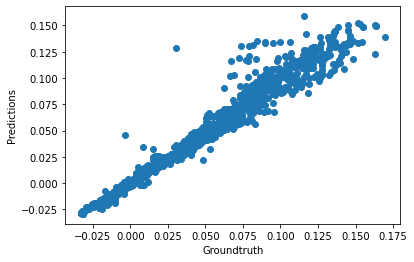

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [19]:
#%store model_fl_com_x

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [21]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [22]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
#               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9649959634742626
RMSE:  0.007671293913140557
The lowest error is:  2.9043328372401617e-07
The highest error is:  0.13986714968999733
The avg. error is:  0.003699261917066132


In [23]:
model_fl_com_y.coef_

array([[-1.86944153e-02,  1.39895138e-02, -1.02943929e-04,
         3.28420020e-02,  1.51798403e-01, -3.46083528e-04,
         4.56170763e-02,  1.94637776e-01,  2.13227006e-02,
         7.24630542e-02,  3.49768962e-03,  3.62617138e-02,
         2.51241432e-02,  2.16634793e-01]])

In [24]:
model_fl_com_y.intercept_

array([0.00170945])

Text(0, 0.5, 'Predictions')

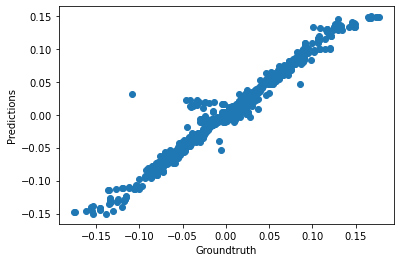

In [25]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [25]:
#%store model_fl_com_y

In [26]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [27]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [28]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
#               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9631050809520509
RMSE:  0.006611628072126092
The lowest error is:  6.219799922297471e-08
The highest error is:  0.13401718470739332
The avg. error is:  0.002031089655143138


In [29]:
model_fl_com_theta.coef_

array([[-7.78555785e-05,  3.29032506e-03,  1.07716470e-01,
        -1.66360459e-03, -2.57589385e-03,  2.83048070e-02,
         2.50267525e-02,  1.53141296e-02,  3.45920475e-02,
         6.10195349e-03,  1.14361089e-02, -2.63185807e-03,
         2.34727112e-02,  3.79376771e-02]])

In [30]:
model_fl_com_theta.intercept_

array([-0.00029858])

Text(0, 0.5, 'Predictions')

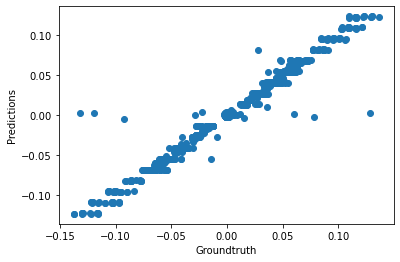

In [31]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")